# Handwritten Digit Classification

We will perform handwritten digit classification using a Gaussian generative model on MNIST Dataset. We will model each class(representing each digit as a multivariate (784-dimensional) Gaussian. The data set of handwritten digits was obtained from:
```
http://yann.lecun.com/exdb/mnist/index.html
```
### Steps
1. We will load the set of training and testing dataset images. We will be defining a function for that.
2. Then we will split the dataset into 2 parts - 1 for *training* and other for *validation*.
3. Then we will fit a **Gaussian generative model** on training dataset. This involves two steps:
    a. Determine class probabilities
    b. Fit a Gaussian for each digit and find its mean and covariance (likelihood)
4. Now we can use Bayes Rule for classification
5. Find the validation error
6. Find the test error

In [1]:
# This is a script to load the MNIST dataset.

%matplotlib inline
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()


In [2]:
# Now we will actually load the datasets. This may take a few seconds

x,y = loadmnist('train-images.idx3-ubyte','train-labels.idx1-ubyte')
testx,testy = loadmnist('t10k-images.idx3-ubyte','t10k-labels.idx1-ubyte')

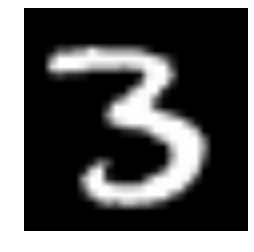

Length of validation set is 10000
Length of training set is 50000
Length of testing set is also 10000


In [3]:
# Let us test printing a train image
displaychar(x[12])
from sklearn.cross_validation import train_test_split
trainx, cvalx, trainy, cvaly = train_test_split(x,y, test_size = 0.16666, random_state = 42)

print "Length of validation set is", len(cvalx)
print "Length of training set is", len(trainx)
print "Length of testing set is also",len(testx)
### We have now split the data sets

In [4]:
# Now we find Gaussian priors pi
priors = {}
for a in range(0,10):
    priors[a] = 0
total = len(trainy)
for x in np.nditer(trainy):
    temp = int(x)
    priors[temp] += 1.0
for key in priors:
    priors[key] /= total
print "Gaussian Priors are:"
print("\n".join("{}: {}".format(ky, val) for ky, val in priors.items()))
print "Sum is", sum(list(priors.values()))


Gaussian Priors are:
0: 0.09878
1: 0.11298
2: 0.09928
3: 0.10262
4: 0.09724
5: 0.09004
6: 0.09874
7: 0.1041
8: 0.09744
9: 0.09878
Sum is 1.0


Observed Digit: 8


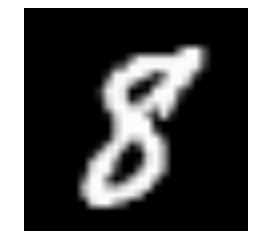

Observed Digit: 8
Actual Digit: 8


In [5]:
# Now to define classifier using Gaussian Multivariate classes
from scipy.stats import multivariate_normal
class_mean = {}
class_cov = {}

for label in range(0,10):
    indices = [i for i, j in enumerate(trainy) if j == label]
    train_label = map(lambda i:trainx[i], indices)
    class_mean[label] = (np.mean(train_label,axis=0))
    class_cov[label] = np.cov(np.transpose(train_label))+np.identity(28*28)

def findclass(test_img):
    test_prob = []
    for label in range(0,10):
        temp = multivariate_normal(class_mean[label],class_cov[label])
        test_prob.append((np.log(priors[label])+temp.logpdf(test_img)))
    
    mx_prob_label = np.argmax(test_prob)
    return mx_prob_label
    
print "Observed Digit:",findclass(test_img = cvalx[2])
displaychar(cvalx[2])
print "Observed Digit:",findclass(test_img = cvalx[2])
print "Actual Digit:",cvaly[2]

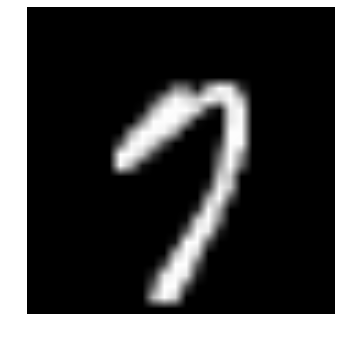

Error in classification: 0.169
List of misclassified labels
0: 48
1: 90
2: 155
3: 231
4: 207
5: 357
6: 67
7: 315
8: 131
9: 89


In [28]:
y_obs = []
err_class = {}   # Define error in each class
mismatch_mat = np.zeros((10,10))

for i in range(0,10):
    err_class[i] = 0
for i in range(0,10000):
    y_obs.append(findclass(test_img = cvalx[i]))
    if(y_obs[i]!=cvaly[i]):
        err_class[cvaly[i]] += 1
    mismatch_mat[cvaly[i]][y_obs[i]] += 1


displaychar(cvalx[7])

print "Error in classification:", float(sum(list(err_class.values())))/10000
print "List of misclassified labels"
print("\n".join("{}: {}".format(ky, val) for ky, val in err_class.items()))


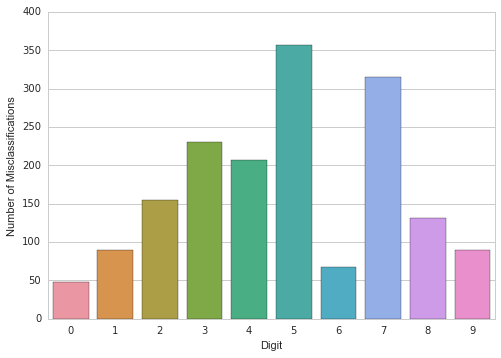

[<matplotlib.text.Text at 0x933b400>, <matplotlib.text.Text at 0x8f914a8>]

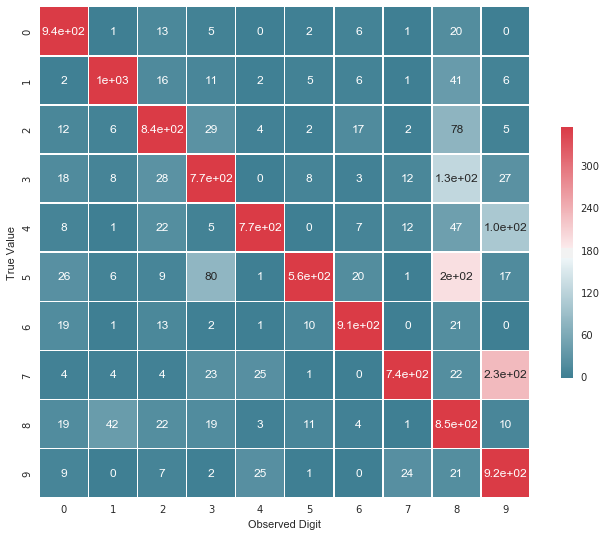

In [30]:
import seaborn as sns
sns.set_style("whitegrid")
err_hist = sns.barplot(x=err_class.keys(), y=err_class.values())
err_hist.set(xlabel='Digit', ylabel='Number of Misclassifications')
plt.show()

vmax = max(list(err_class.values()))


f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
corr_mat = sns.heatmap(mismatch_mat, cmap=cmap, vmax=vmax, vmin = 0,\
            square=True, xticklabels=True, yticklabels=True,\
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,annot=True)
corr_mat.set(xlabel='Observed Digit', ylabel='True Value')
